In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# Finch Beaks
Every year for the past 40-plus years, Peter and Rosemary Grant have gone to the Galápagos island of Daphne Major and collected data on Darwin's finches. Using your skills in statistical inference, you will spend this chapter with their data, and witness first hand, through data, evolution in action. It's an exhilarating way to end the course!

In [2]:
finch1975 = pd.read_csv('Datasets/finch_beaks_1975.csv')
column1 = ['band', 'species', 'blength', 'bdepth']
finch1975.columns = column1
finch1975['year'] = 1975
print(finch1975.head(1))
finch2012 = pd.read_csv('Datasets/finch_beaks_2012.csv')
finch2012.columns = column1
finch2012['year'] = 2012
print(finch2012.head(1))
allfinch = pd.concat([finch1975, finch2012], sort=False)
print(allfinch.head(1))

   band species  blength  bdepth  year
0     2  fortis      9.4     8.0  1975
    band species  blength  bdepth  year
0  19022  fortis     10.0     8.5  2012
   band species  blength  bdepth  year
0     2  fortis      9.4     8.0  1975


## 1) Swarmplot of the beak depth of Scandens (species of finch) in 1975 and in 2012.

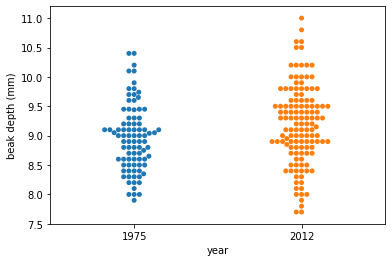

In [3]:
allscandens = allfinch[allfinch.species == 'scandens']
# Create bee swarm plot
_ = sns.swarmplot(x='year', y='bdepth', data=allscandens)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

## 2) ECDFs of beak depths of Scandens 

In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

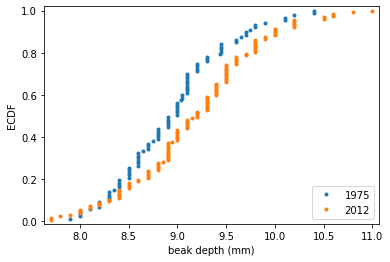

In [5]:
bd_1975 = allscandens[allscandens.year==1975].bdepth
bd_2012 = allscandens[allscandens.year==2012].bdepth

# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.

## 3) Parameter estimates of beak depths (Estimate the difference of the mean beak depth of the G. scandens)

In [6]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [7]:
# Compute the difference of the sample means: mean_diff
mean_diff = bd_2012.mean() - bd_1975.mean()

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('difference of means of replicate samples =', bs_diff_replicates.mean(), 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.2262204724409429 mm
difference of means of replicate samples = 0.22680545940809166 mm
95% confidence interval = [0.05996423 0.38961202] mm


## 4) Hypothesis test: Are beaks deeper in 2012?
What is the probability that we would get the observed difference in mean beak depth if the means were the same?
<br>The hypothesis is that the means are equal.
<br>To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [8]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates2 = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value: p
p = np.sum(bs_diff_replicates2 >= mean_diff) / len(bs_diff_replicates2)

# Print p-value
print('Difference of means =', mean_diff, 'mm')
print('Difference of means of replicate samples =', bs_diff_replicates.mean(), 'mm')
print('Difference of means of shifted replicate samples =', bs_diff_replicates2.mean(), 'mm')
print('Probability of our hypothesis is p =', p)

Difference of means = 0.2262204724409429 mm
Difference of means of replicate samples = 0.22680545940809166 mm
Difference of means of shifted replicate samples = -0.000690119829845238 mm
Probability of our hypothesis is p = 0.0038


We get a p-value of 0.0043, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

## 5) EDA of beak length and depth

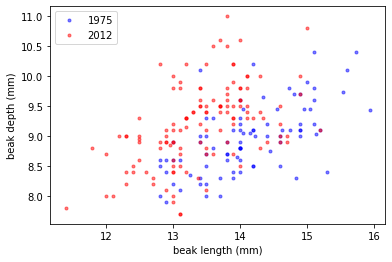

In [9]:
bl_1975 = allscandens[allscandens.year==1975].blength
bl_2012 = allscandens[allscandens.year==2012].blength

# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; <b>they became shorter and deeper.

## 6) Linear regressions 
Perform a linear regression for both the 1975 and 2012 data. Then, perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line. You have to use 

In [10]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [11]:
bl_1975 = np.array(bl_1975); bd_1975 = np.array(bd_1975); bl_2012 = np.array(bl_2012); bd_2012 = np.array(bd_2012)

# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(bl_1975, bd_1975, size=1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(bl_2012, bd_2012, size=1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975, '   conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975, 'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012, '    conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012, 'conf int =', intercept_conf_int_2012)

1975: slope = 0.46520516916059357    conf int = [0.33356113 0.5987709 ]
1975: intercept = 2.3908752365842285 conf int = [0.50990019 4.26260148]
2012: slope = 0.4626303588353126     conf int = [0.33557688 0.60606828]
2012: intercept = 2.9772474982360184 conf int = [1.08964083 4.68620705]


It looks like they have the same slope, but different intercepts.

### Displaying the linear regression results of bootstrap lines

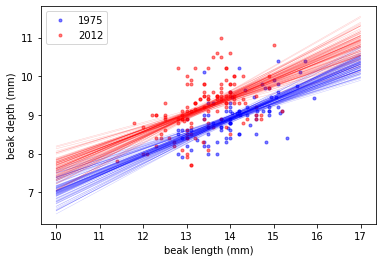

In [12]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

## 7) Beak length to depth ratio

In [13]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = ratio_1975.mean()
mean_ratio_2012 = ratio_2012.mean()

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975, 'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012, 'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55689293 1.6014981 ]
2012: mean ratio = 1.4658342276847767 conf int = [1.44507296 1.48804551]


The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

## 8) EDA of heritability

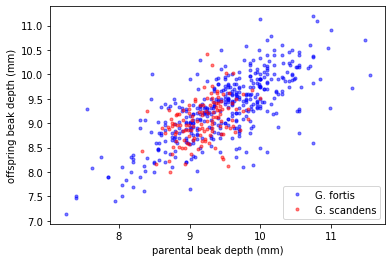

In [14]:
fortis_off = pd.read_csv('Datasets/fortis_beak_depth_heredity.csv')
scandens_off = pd.read_csv('Datasets/scandens_beak_depth_heredity.csv')

bd_parent_scandens = scandens_off['mid_parent'] 
bd_offspring_scandens = scandens_off['mid_offspring']
bd_parent_fortis = (fortis_off['Male BD'] + fortis_off['Female BD']) / 2
bd_offspring_fortis = fortis_off['Mid-offspr']

# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()

It appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis. We'll quantify this correlation next.

### Correlation and Pearson correlation of offspring and parental data

In [15]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

In [16]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [17]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, pearson_r, size=1000)
bs_replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, pearson_r, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401259 [0.26297739 0.54373043]
G. fortis: 0.7283412395518485 [0.6675323  0.78055439]


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

## 9) Measuring heritability
You have to divide covariance_matrix[0,1] by covariance_matrix[0,0].

In [18]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens,
                                     bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis,
                                   bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685983 [0.3516412  0.73813801]
G. fortis: 0.7229051911438154 [0.64828517 0.7940889 ]


We see that G. fortis has stronger heritability than G. scandens. This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.

## 10) Is beak depth heritable at all in G. scandens?
You will test that hypothesis that there is a heritable in G.Scandens. To do this, you will do a <b>pairs permutation test</b>.

In [20]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)

p-val = 0.0


You get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis. If you like, you can plot a histogram of the heritability replicates to get a feel for how extreme of a value of heritability you might expect by chance.

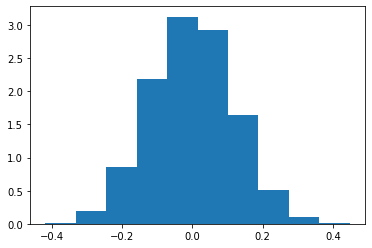

In [21]:
plt.hist(perm_replicates, density = True)
plt.show()